<a href="https://colab.research.google.com/github/Alvaro-Fdz-Glz/TFM/blob/master/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix - Experiment 1


In [25]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.


     |████████████████████████████████| 993kB 9.6MB/s 


In [0]:
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1KLNitsvBYGXnfch59-cqMrQKjRXa1Twf'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

downloaded.GetContentFile('sellout-proveedor2.csv')  
val_2 = pd.read_csv('sellout-proveedor2.csv')


# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1Bv0WMQMeHGbWEf9FA2cHqUUa0oHe-fA7'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

downloaded.GetContentFile('sellout-proveedor1.csv')  
val = pd.read_csv('sellout-proveedor1.csv')

def replacedollar(vl):
    vl=vl.replace("$","") 
    return np.float(vl)

val_2.Price=val_2.Price.map(replacedollar)

val_2.columns=list(val)


In [48]:
#Exploring the data
val.head() 

,Sku,Date,Store_Id,Units,Price
0,4220015,2017-01-01 SO Diaria Piezas,18,6.0,15.6
1,4220015,2017-01-01 SO Diaria Piezas,24,0.0,0.0
2,4220015,2017-01-01 SO Diaria Piezas,39,0.0,0.0
3,4220015,2017-01-01 SO Diaria Piezas,44,0.0,0.0
4,4220015,2017-01-01 SO Diaria Piezas,46,0.0,0.0


In [0]:
d={}
#Obtaining the list of different products 
t=np.unique(val.Sku)

#Spliting the information by each shop
for shop in np.unique(val.Store_Id)[0:4]:
    temp=val[val.Store_Id==shop]
    dat=pd.DataFrame()
    for i in t:
        try:
            #Differencing values with previous day sales                     
            dat[i]=np.array((temp.Units[temp.Sku==i]*temp.Price[temp.Sku==i]))
            dat[i]=dat[i].diff()
        except:
            dat[i]=0
        #print(dat[i].diff())
    dat=dat.fillna(0)
    d[shop]=dat

In [0]:
#Number of images generated for each shop
num_images=100 
# Number of columns selected for each transformation
num_columns_transformation=10 
# Number of experiments
num_transformations=30 
transformations=pd.DataFrame()

# Random choice of the columns for defining each experiment
for i in range(num_transformations): 
    columns=np.random.choice(a=29,replace=False,size=num_columns_transformation)
    transformations[i]=columns
    
# Giving the matrix the desired format    
transformations=transformations.transpose()

In [0]:
#Initializing an empty data frame for the new dataset to be predicted
data_shop=pd.DataFrame()
#Generating random numbers for obtaining new instances
rows=np.random.choice(a=140,replace=False,size=num_images) 
for trans in range(num_transformations):
    data=pd.DataFrame()
    # Following loop generates the new instances 
    for i in range(num_images): 
        img=d[4].iloc[rows[i]:rows[i]+7,transformations.iloc[trans,:]]
        img_fl=np.array(img).flatten()
        # Standardizing the 
        img_fl-=img_fl.min()
        img_fl/=img_fl.max()
        # Number of bins for the computation of the histogram
        bins_val=20
        # Standardization of the histogram
        img_fl_hist=np.histogram(img_fl,bins=bins_val)[0]/sum(np.histogram(img_fl,bins=bins_val)[0]) 
        data[i]=img_fl_hist
    data=data.transpose()
    #Labeling the new instance
    data['label']=trans 
    data.index=rows
    #Concetanating the new instance to the entire previous instances
    data_shop=pd.concat([data_shop,data]) 

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 

#Spliting into train/test
X_train, X_test, y_train, y_test = train_test_split(data_shop.iloc[:,:20], data_shop.iloc[:,20], train_size=0.75, test_size=0.25) 

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

X=data_shop.iloc[:,:20] 
y=data_shop.iloc[:,20]

#Defining a list of posible values for number of estimators for the xgboost
val=[i*50 for i in np.arange(7,10)] 
randm_params={'n_estimators':val,
           'max_depth':np.arange(2,6),
            'learning_rate':np.linspace(start=.005,stop=.1,num=10)}

#Randomized search of the best parameters for the tunning the classifier
rscv=RandomizedSearchCV(n_jobs=-1,cv=3,param_distributions=randm_params,estimator=XGBClassifier(),n_iter=1) 
rscv.fit(X,y)
param_=rscv.best_params_

In [0]:
# Manually imputing the best parameteres obtained from prevoius random search
xgbc=XGBClassifier(learning_rate=0.02611,max_depth=4,n_estimators=400,objective='multi:softprob') 
# Fiting the classifier
xgbc.fit(X_train,y_train) 

temp=xgbc.predict_proba(X_test) # Using the model to predict the class

val=[]
for i in range(temp.shape[0]):
  #Obtaining the sum of the exponential of the probabilities
    val.append(np.exp(temp[i]).sum()) 
    
import seaborn as sns

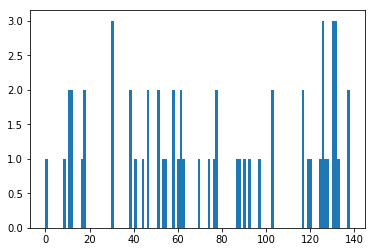

In [73]:
freq=plt.hist(X_test.index[np.array(val)>31.2],bins=120)

In [74]:
#Obtaining the image with the highest values 
np.where(freq[0]==np.max(freq[0])) 

(array([ 26, 109, 113, 114]),)

## Appendix - Experiment 2

In [0]:
#Importing the requires libraries
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.datasets import load_breast_cancer
#Importing the dataset from sklearn
dataset=load_breast_cancer() 

#Set seed for reproducibility of the experiments
np.random.seed(0) 

In [0]:
num_experiments=40 #Defining the number of experiments
partition={}
temp=np.arange(dataset.target.shape[0])
# Defining the normal class / outliers

partition['positive']=np.array(temp[dataset.target==1])
partition['negative']=np.array(temp[dataset.target==0])
##
partition['positive_train']=np.random.choice(partition['positive'], int(partition['positive'].shape[0]*0.80), replace=False)
partition['positive_test']=np.setdiff1d(partition['positive'],partition['positive_train'])

partition['negative_train']=np.random.choice(partition['negative'], int(partition['negative'].shape[0]*0.80), replace=False)
partition['negative_test']=np.setdiff1d(partition['negative'],partition['negative_train'])

##
partition['positive_transformed']=np.array([np.array(partition['positive'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['negative_transformed']=np.array([np.array(partition['negative'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
##
partition['positive_transformed_train']=np.array([np.array(partition['positive_train'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['positive_transformed_test']=np.setdiff1d(partition['positive_transformed'],partition['positive_transformed_train'])

partition['negative_transformed_train']=np.array([np.array(partition['negative_train'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['negative_transformed_test']=np.setdiff1d(partition['negative_transformed'],partition['negative_transformed_train'])


In [0]:
# Preprocessing the information, fitting the standard scaler 
std_scaler=preprocessing.StandardScaler().fit(dataset.data[partition['negative_train']]) 
# Scaling the whole dataset
dataset.data=std_scaler.transform(dataset.data) 


In [0]:
 #Transforming from numpy to torch tensor to pass through the neural network
X_tensor=torch.tensor(np.array(dataset.data))
# Formating the values
X_tensor=X_tensor.float() 

In [0]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining first layer for the first forward function
        self.fc1 = nn.Linear(30, 300) 
        # Defining output layer for second forward function
        self.fc2 = nn.Linear(300, 30)
        # Defining first layer for second forward function
        self.fc3 = nn.Linear(30, 300) 
        # Defining output layer for second forward function
        self.fc4 = nn.Linear(300, 30)
       
    def forward(self, x,layer=1):
        # make sure input tensor is flattened
        x = x.view(-1,x.shape[0])
        # Creating one of the neural networks for making the tranformations
        for i in range(layer):
          x = F.relu(self.fc1(x))
          x = F.celu(self.fc2(x))
        return x
      
    def forward_1(self, x,layer=1):
        # make sure input tensor is flattened
        x = x.view(-1,x.shape[0])
        # Creating one of the neural networks for making the transformations

        for i in range(layer):
          x = F.celu(self.fc3(x))
          x = F.celu(self.fc4(x))
        return x

In [0]:
torch.manual_seed(3)
label=np.empty((0))
rep=2

val_2=torch.Tensor(0,30) 

# This loop creates the new instances
for idx in range(num_experiments): 
  # New neural network definition per each experiment
  temp=Classifier() 
  if idx<=10:
    val_1=torch.Tensor(0,30)
    for x in X_tensor:
      # Generating new instances
      val_1=torch.cat((val_1,temp.forward(x,rep))) 
      #Generating the label for new instance
      label=np.append(label,idx) 
      #Scaling the results from the instance definition
    scaler = preprocessing.StandardScaler().fit(val_1.detach().numpy()) 
    val_1=torch.tensor(scaler.fit_transform(val_1.detach().numpy())) 
  
  if idx>10:
    val_1=torch.Tensor(0,30)
    for x in X_tensor:
      val_1=torch.cat((val_1,temp.forward_1(x,rep)))
      label=np.append(label,idx)
    scaler = preprocessing.StandardScaler().fit(val_1.detach().numpy())
    val_1=torch.tensor(scaler.fit_transform(val_1.detach().numpy()))
  
      
  val_2=torch.cat((val_2,val_1))
# Detaching torch tensor to use it as  numpy array
val=val_2.detach().numpy() 


In [81]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Generating new xgboost classifier
xgbc=XGBClassifier(n_estimators=150,objective='multi:softprob') 
# Fiting the classifier
xgbc.fit(val[partition['negative_transformed_train']],
         label[partition['negative_transformed_train']])


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
step=dataset.data.shape[0]
#Making predictions  of the whole instances obtained applying the transformation
result=np.exp(xgbc.predict_proba(val)).sum(axis=1) 

#Averaging the score of the transformed instances
normality_score=np.array([np.mean([result[i+j*step] for j in range(num_experiments)]) for i in range(step)]) 

In [0]:
#Defining an auxiliary function for plotting results
def ecdf(data,right=True): 
    """ Compute ECDF """
    x = np.sort(data)
    if not(right):
      x=x[::-1]
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
  


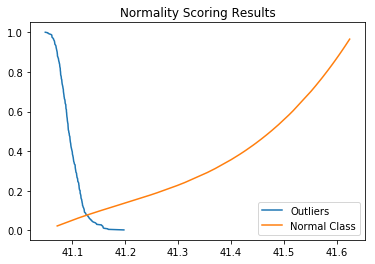

In [84]:
# Plotting the results
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import splrep, splev

(x,y)=ecdf(normality_score[partition['positive']],right=False)

plt.plot(x,y,label='Outliers')

(x,y)=ecdf(normality_score[partition['negative_test']])

bspl = splrep(x,y,s=5)
bspl_y = splev(x,bspl)
plt.plot(x,bspl_y,label='Normal Class')

plt.legend()
plt.title("Normality Scoring Results")
plt.show()



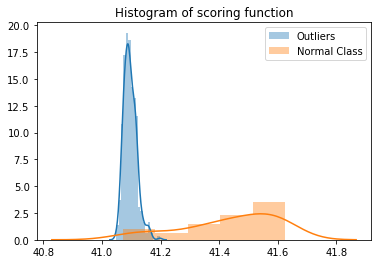

In [85]:
import seaborn as sns

plt.figure()

a=sns.distplot(normality_score[partition['positive']],label='Outliers')
a=sns.distplot(normality_score[partition['negative_test']],label="Normal Class")

plt.title("Histogram of scoring function")
plt.legend()
plt.show()

## Appendix 3

In [0]:
#For this experiment, the code used was the same as in the previous experiment
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.datasets import load_digits

dataset=load_digits()
dataset.data.shape

np.random.seed(0)

In [87]:
np.unique(dataset.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
num_experiments=40
partition={}
temp=np.arange(dataset.target.shape[0])
##
partition['positive']=np.array(temp[dataset.target!=7])
partition['negative']=np.array(temp[dataset.target==7])
##
partition['positive_train']=np.random.choice(partition['positive'], int(partition['positive'].shape[0]*0.90), replace=False)
partition['positive_test']=np.setdiff1d(partition['positive'],partition['positive_train'])

partition['negative_train']=np.random.choice(partition['negative'], int(partition['negative'].shape[0]*0.90), replace=False)
partition['negative_test']=np.setdiff1d(partition['negative'],partition['negative_train'])

##
partition['positive_transformed']=np.array([np.array(partition['positive'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['negative_transformed']=np.array([np.array(partition['negative'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
##
partition['positive_transformed_train']=np.array([np.array(partition['positive_train'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['positive_transformed_test']=np.setdiff1d(partition['positive_transformed'],partition['positive_transformed_train'])

partition['negative_transformed_train']=np.array([np.array(partition['negative_train'])+i*dataset.data.shape[0] for i in range(num_experiments)]).flatten()
partition['negative_transformed_test']=np.setdiff1d(partition['negative_transformed'],partition['negative_transformed_train'])

In [0]:
std_scaler=preprocessing.StandardScaler().fit(dataset.data[partition['negative_train']])
dataset.data=std_scaler.transform(dataset.data)

In [0]:
#Pasando a tensor para trabajar con pytorch
import numpy as np
X_tensor=torch.tensor(np.array(dataset.data))
X_tensor=X_tensor.float()

In [0]:
#Generando la 
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 120)
        self.fc4 = nn.Linear(120, 64)
       
    def forward(self, x,layer=1):
        # make sure input tensor is flattened
        x = x.view(-1,x.shape[0])
        for i in range(layer):
          x = F.relu(self.fc1(x))
          x = F.celu(self.fc2(x))
        return x
      
    def forward_1(self, x,layer=1):
        # make sure input tensor is flattened
        x = x.view(-1,x.shape[0])
        for i in range(layer):
          x = F.relu(self.fc3(x))
          x = F.celu(self.fc4(x))
        return x

In [0]:
torch.manual_seed(3)
label=np.empty((0))
rep=2

val_2=torch.Tensor(0,64)


for idx in range(num_experiments):
  temp=Classifier()
  if idx<=10:
    val_1=torch.Tensor(0,64)
    for x in X_tensor:
      val_1=torch.cat((val_1,temp.forward(x,rep)))
      label=np.append(label,idx)
    scaler = preprocessing.StandardScaler().fit(val_1.detach().numpy())
    val_1=torch.tensor(scaler.fit_transform(val_1.detach().numpy()))
  
  if idx>10:
    val_1=torch.Tensor(0,64)
    for x in X_tensor:
      val_1=torch.cat((val_1,temp.forward_1(x,rep)))
      label=np.append(label,idx)
    scaler = preprocessing.StandardScaler().fit(val_1.detach().numpy())
    val_1=torch.tensor(scaler.fit_transform(val_1.detach().numpy()))
  
      
  val_2=torch.cat((val_2,val_1))

val=val_2.detach().numpy()


In [93]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
xgbc=XGBClassifier()
xgbc=XGBClassifier(n_estimators=150)
xgbc.fit(val[partition['negative_transformed_train']],
         label[partition['negative_transformed_train']])


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
step=dataset.data.shape[0]

result=np.exp(xgbc.predict_proba(val)).sum(axis=1)

normality_score=np.array([np.mean([result[i+j*step] for j in range(num_experiments)]) for i in range(step)])

In [0]:
def ecdf(data,right=True):
    """ Compute ECDF """
    x = np.sort(data)
    if not(right):
      x=x[::-1]
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
  

For understanding 


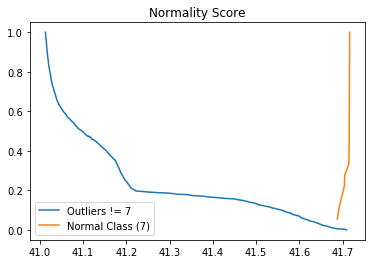

In [96]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import splrep, splev

(x,y)=ecdf(normality_score[partition['positive']],right=False)

plt.plot(x,y,label='Outliers != 7')

(x,y)=ecdf(normality_score[partition['negative_test']])

bspl = splrep(x,y,s=6)
bspl_y = splev(x,bspl)
plt.plot(x,y,label='Normal Class (7)')

plt.legend()
print("For understanding ")
plt.title("Normality Score")
plt.show()

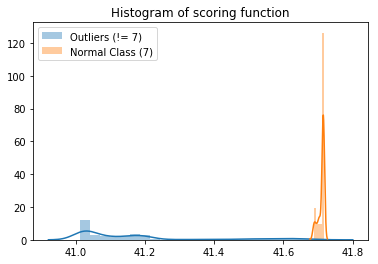

In [97]:
import seaborn as sns

plt.figure()

a=sns.distplot(normality_score[partition['positive']],label='Outliers (!= 7)')
a=sns.distplot(normality_score[partition['negative_test']],label="Normal Class (7)")

plt.title("Histogram of scoring function")
plt.legend()
plt.show()